In [2]:
#Datenerfassung
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

#Filepath
white = '/home/dl4/dst/Winequality_White.xlsx'

red = '/home/dl4/dst/Winequality_Red.xlsx'
full_colored = '/home/dl4/dst/Winequality_full.xlsx'

#Data with color
df_listC = pd.read_excel(full_colored)

df_listCnoNA = df_listC.dropna()
#Clean quality from 99 and 17 values
df_temp= df_listCnoNA[df_listCnoNA['quality']!=99]
df_listCnoNAClean =df_temp[df_temp['quality']!=17]
df_listCnoNAClean =df_listCnoNAClean[df_listCnoNAClean['pH']!=99.99] 
#df_listCnoNAClean -> Beide Weinsorten mit Farbenlabel ohne falsche pH und Quality Werte

#Auftrennung in Datensatz Rotwein und Datensatz Weißwein
df_red = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "red"]
df_white = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "white"]

df_red_org = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "red"]
df_white_org = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "white"]

#Label und ID Säule entfernen
df_red = df_red.drop(["color", "ID"], axis=1)
df_white = df_white.drop(["color", "ID"], axis=1).reset_index(drop=True)

wine_list = [df_white, df_red]
df_white


# Rot/Weißwein Dataset ohne "ID" und "quality"
x_red = df_red_org.iloc[:,1:15]
x_white = df_white_org.iloc[:,1:15]
# Label-Daten ("quality")
y_red = df_red_org.iloc[:,15]
y_white = df_white_org.iloc[:,15]



# "flavanoids entfernen"
x_red = x_red.drop("flavanoids", axis=1)
x_white = x_white.drop("flavanoids", axis=1)


#Train and test Data

#x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(df_listCnoNAClean.iloc[:,0:15], df_listCnoNAClean.iloc[:,15], test_size=0.2, random_state=1)
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(df_red_org.iloc[:,1:15], df_red_org.iloc[:,15], test_size=0.2, random_state=1)
x_train_white, x_test_white, y_train_white, y_test_white = train_test_split(df_white_org.iloc[:,1:15], df_white_org.iloc[:,15], test_size=0.2, random_state=1)


In [3]:
#Skalierung
def min_max_scaler(x):
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(x)
    df_scaled = pd.DataFrame(scaled, columns = x.columns)
    
    return df_scaled


def robust_scaler(x):
    
    scaler = RobustScaler()
    scaled = scaler.fit_transform(x)
    df_scaled = pd.DataFrame(scaled, columns = x.columns)
    
    return df_scaled

#MinMax Datensatz
x_red_scaled = min_max_scaler(x_red)
x_white_scaled = min_max_scaler(x_white)

#Robust Datensatz
x_red_robust = min_max_scaler(x_red)
x_white_robust = min_max_scaler(x_white)

In [4]:
#Outlier removal

def outlier_removal(x_df, y_df):
    #Konvertieren zu Numpy-Array für weitere Bearbeitung
    x = x_df.to_numpy()
    y = y_df.to_numpy()
    
    ######################
    ###Isolation Forest###
    ######################
    iso_forest = IsolationForest(contamination=0.05, random_state=1)
    outlier = iso_forest.fit_predict(x)
    # Boolean Array mit Outlier = False
    mask = outlier != -1
    # Array mit Inliner
    x_iso, y_iso = x[mask, :], y[mask]
    # Dataframe erstellen
    x_iso_df = pd.DataFrame(x_iso, columns=x_df.columns)
    y_iso_df = pd.DataFrame(y_iso, columns=["quality"])
    
    ##########################
    ###Local Outlier Factor###
    ##########################
    outlier = LocalOutlierFactor().fit_predict(x)
    mask = outlier != -1
    #Array mit Inliner
    x_lof, y_lof = x[mask, :], y[mask]
    # Dataframe erstellen
    x_lof_df = pd.DataFrame(x_lof, columns=x_df.columns)
    y_lof_df = pd.DataFrame(y_lof, columns=["quality"])
    
    ####################################
    ###Minimum Covariance Determinant###
    ####################################
    outlier = EllipticEnvelope(contamination=0.05,random_state=1).fit_predict(x)
    mask = outlier != -1
    #Array mit Inliner
    x_mcd, y_mcd = x[mask, :], y[mask]
    # Dataframe erstellen
    x_mcd_df = pd.DataFrame(x_mcd, columns=x_df.columns)
    y_mcd_df = pd.DataFrame(y_mcd, columns=["quality"])
    
    ###################
    ###One-Class SVM###
    ###################
    outlier = OneClassSVM(nu=0.05).fit_predict(x)
    mask = outlier != -1
    #Array mit Inliner
    x_ocs, y_ocs = x[mask, :], y[mask]
    # Dataframe erstellen
    x_ocs_df = pd.DataFrame(x_ocs, columns=x_df.columns)
    y_ocs_df = pd.DataFrame(y_ocs, columns=["quality"])
    
    
    
    return (x_iso_df, y_iso_df), (x_lof_df, y_lof_df), (x_mcd_df, y_mcd_df), (x_ocs_df, y_ocs_df)

iso, lof, mcd, ocs = outlier_removal(x_red_scaled, y_red)

x_red_iso, y_red_iso = iso
x_red_lof, y_red_lof = lof
x_red_mcd, y_red_mcd = mcd
x_red_ocs, y_red_ocs = ocs

iso, lof, mcd, ocs = outlier_removal(x_white_scaled, y_white)

x_white_iso, y_white_iso = iso
x_white_lof, y_white_lof = lof
x_white_mcd, y_white_mcd = mcd
x_white_ocs, y_white_ocs = ocs

#print(x_white_filtered)
print(len(x_white), len(x_white_iso), len(x_white_lof), len(x_white_mcd), len(x_white_ocs))
print(len(x_red), len(x_red_iso), len(x_red_lof), len(x_red_mcd), len(x_red_ocs))

4881 4637 4843 4636 4640
1564 1485 1518 1485 1484


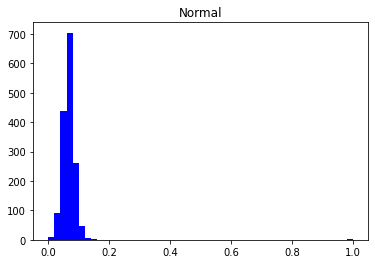

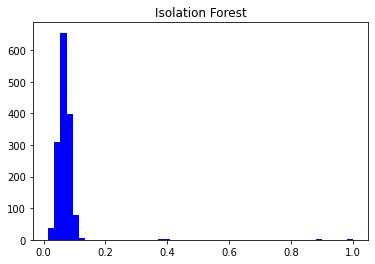

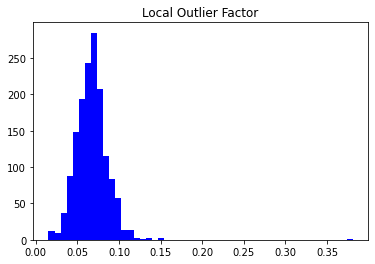

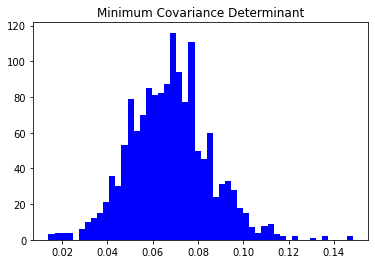

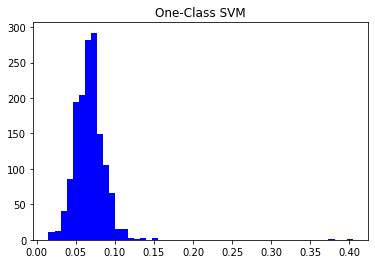

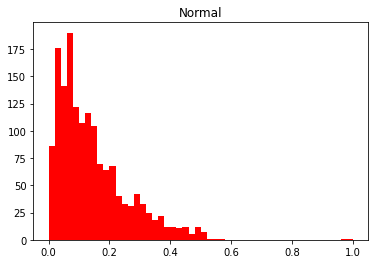

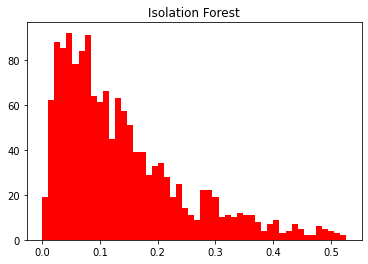

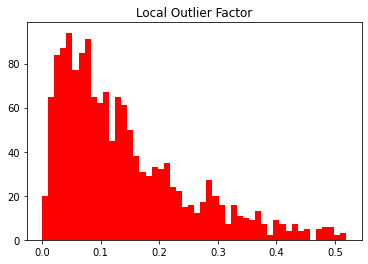

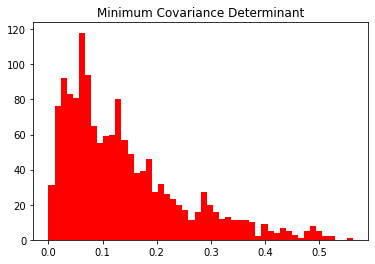

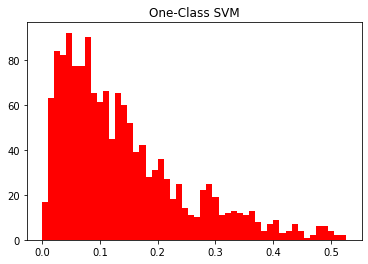

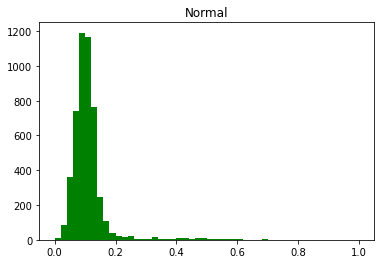

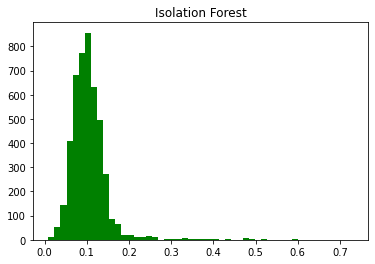

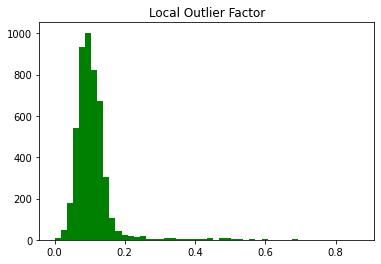

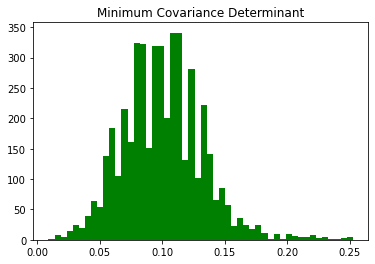

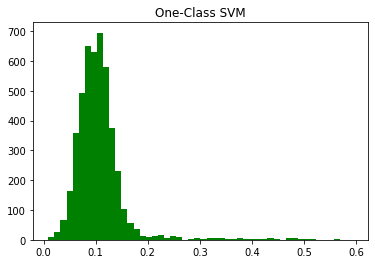

In [23]:
# Visualisierung: w/ outlier w/o outlier
num_bins = 50

### pH Plots ###

print("\n\n")

plt.hist(x_red_scaled["pH"], num_bins, facecolor = "b")
plt.title("Normal")
plt.show()

plt.hist(x_red_iso["pH"], num_bins, facecolor = "b")
plt.title("Isolation Forest")
plt.show()

plt.hist(x_red_lof["pH"], num_bins, facecolor = "b")
plt.title("Local Outlier Factor")
plt.show()

plt.hist(x_red_mcd["pH"], num_bins, facecolor = "b")
plt.title("Minimum Covariance Determinant")
plt.show()

plt.hist(x_red_ocs["pH"], num_bins, facecolor = "b")
plt.title("One-Class SVM")
plt.show()

### Total Sulfur Dioxide Plots ###

plt.hist(x_red_scaled["total sulfur dioxide"], num_bins, facecolor = "r")
plt.title("Normal")
plt.show()

plt.hist(x_red_iso["total sulfur dioxide"], num_bins, facecolor = "r")
plt.title("Isolation Forest")
plt.show()

plt.hist(x_red_lof["total sulfur dioxide"], num_bins, facecolor = "r")
plt.title("Local Outlier Factor")
plt.show()

plt.hist(x_red_mcd["total sulfur dioxide"], num_bins, facecolor = "r")
plt.title("Minimum Covariance Determinant")
plt.show()

plt.hist(x_red_ocs["total sulfur dioxide"], num_bins, facecolor = "r")
plt.title("One-Class SVM")
plt.show()


### Chlorides ###

plt.hist(x_white_scaled["chlorides"], num_bins, facecolor = "g")
plt.title("Normal")
plt.show()

plt.hist(x_white_iso["chlorides"], num_bins, facecolor = "g")
plt.title("Isolation Forest")
plt.show()

plt.hist(x_white_lof["chlorides"], num_bins, facecolor = "g")
plt.title("Local Outlier Factor")
plt.show()

plt.hist(x_white_mcd["chlorides"], num_bins, facecolor = "g")
plt.title("Minimum Covariance Determinant")
plt.show()

plt.hist(x_white_ocs["chlorides"], num_bins, facecolor = "g")
plt.title("One-Class SVM")
plt.show()

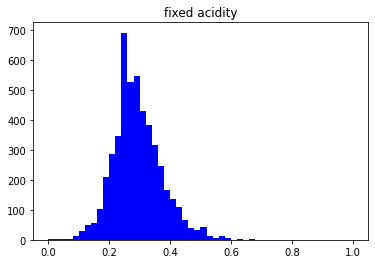

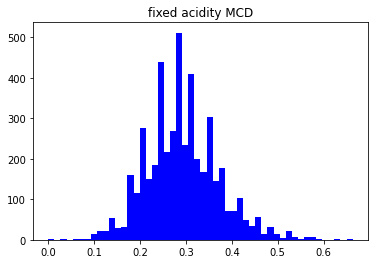

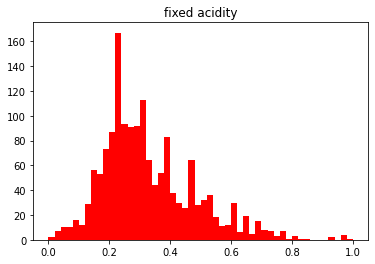

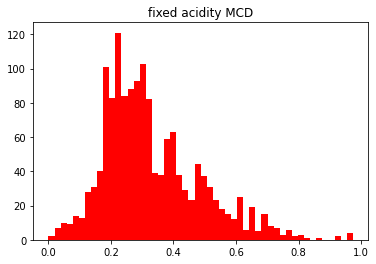

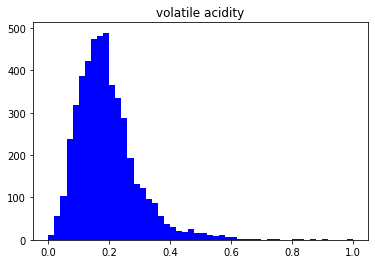

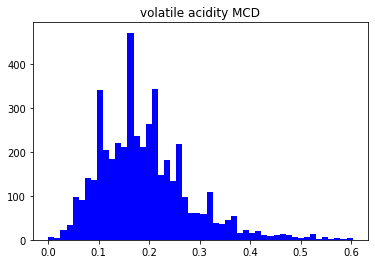

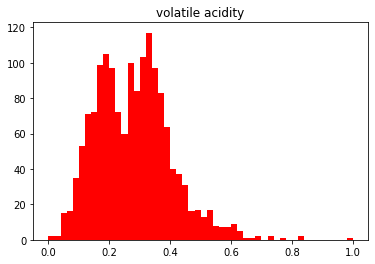

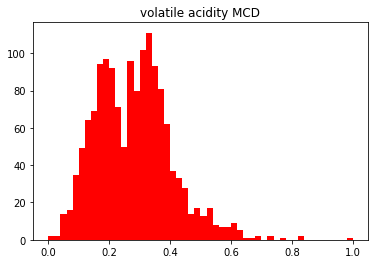

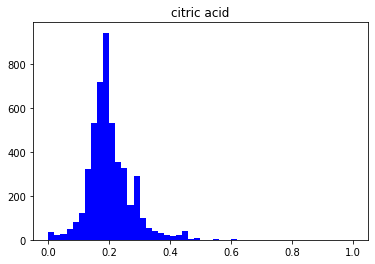

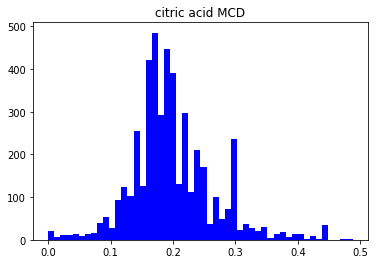

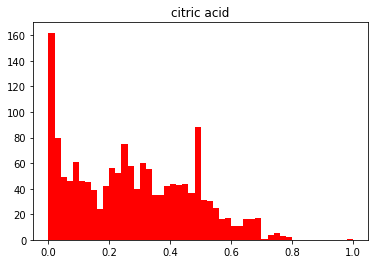

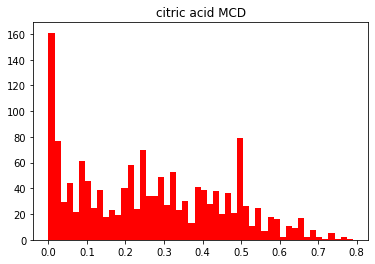

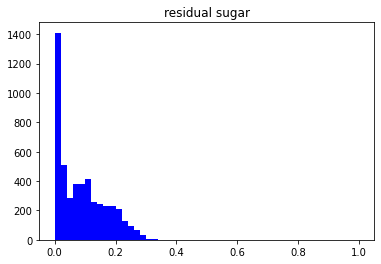

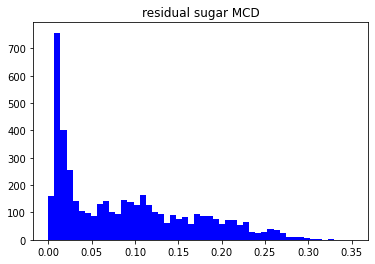

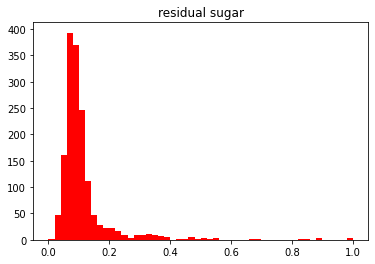

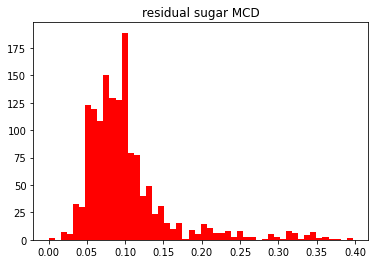

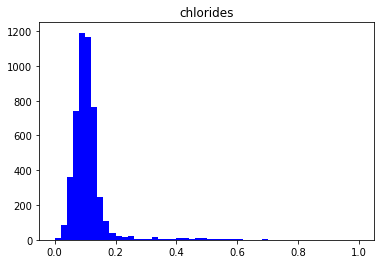

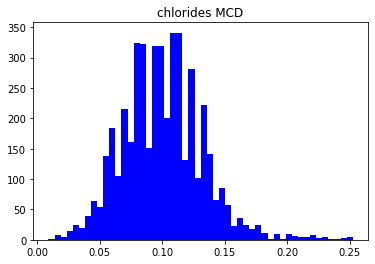

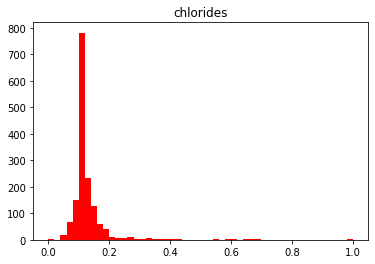

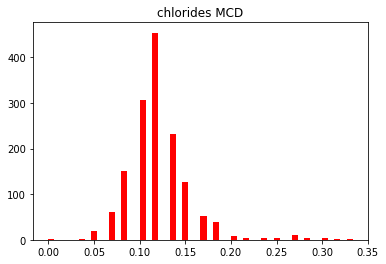

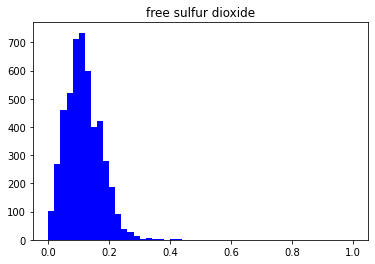

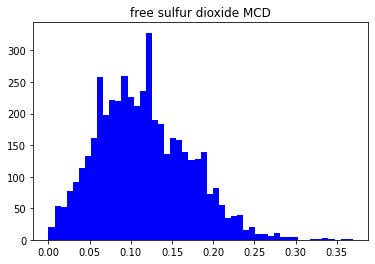

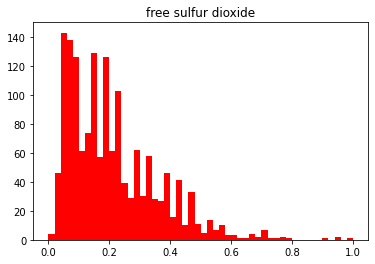

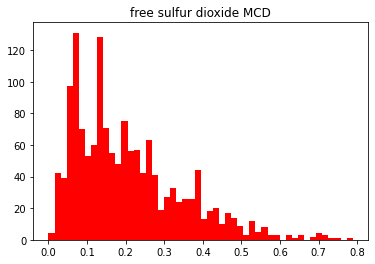

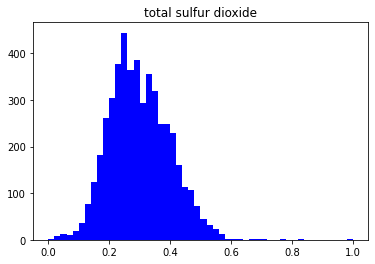

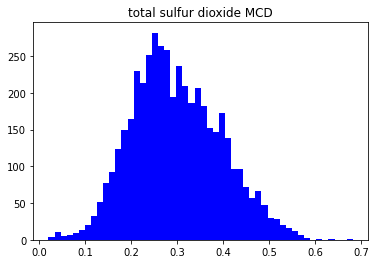

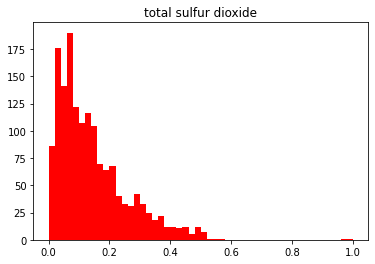

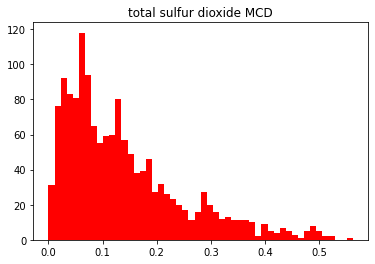

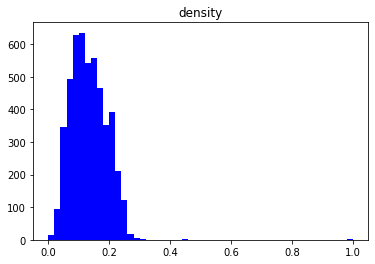

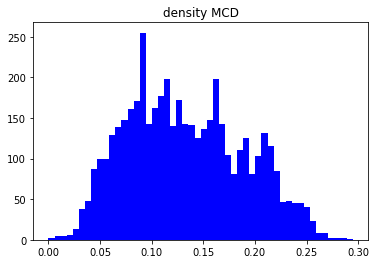

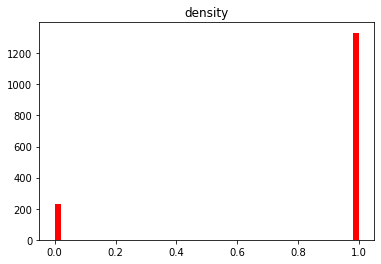

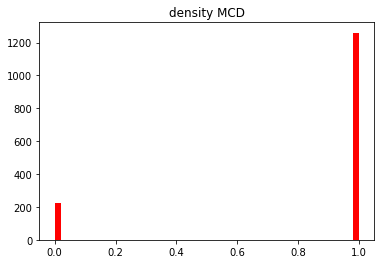

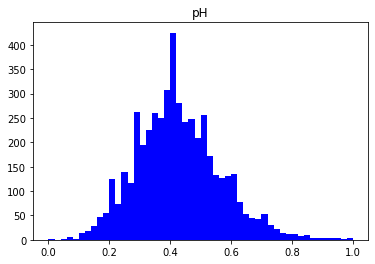

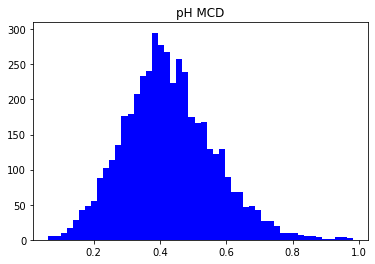

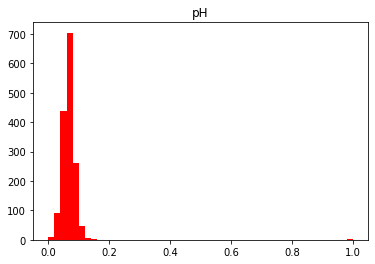

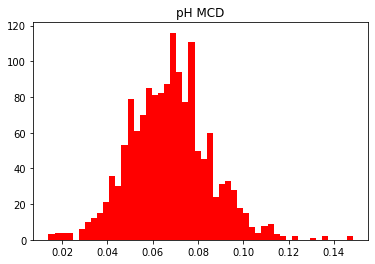

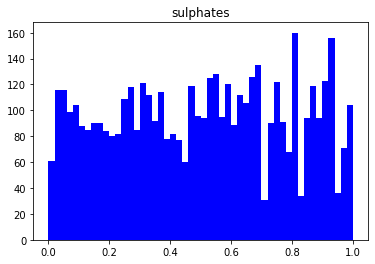

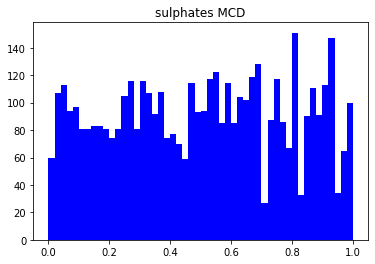

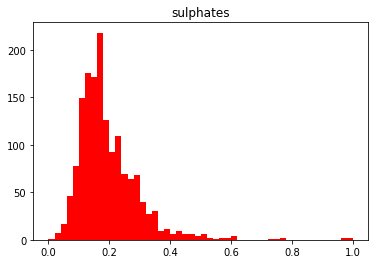

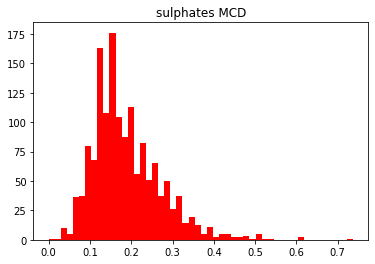

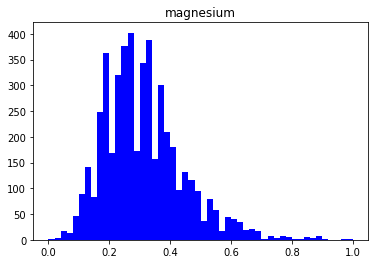

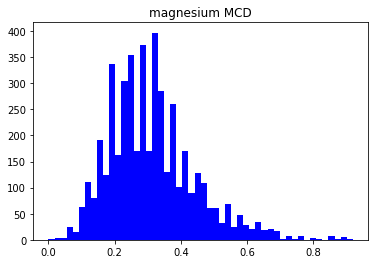

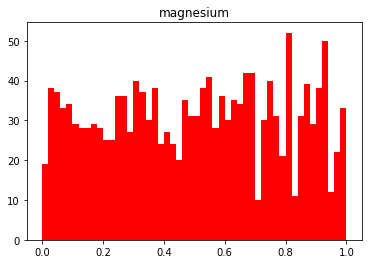

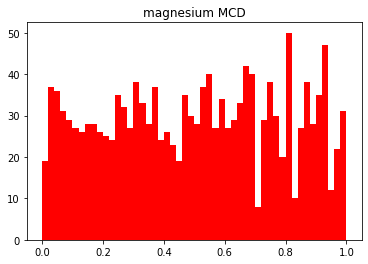

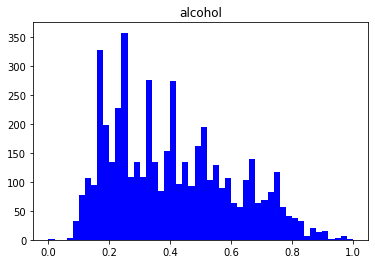

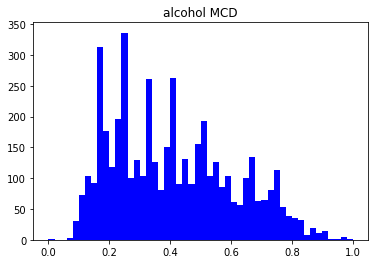

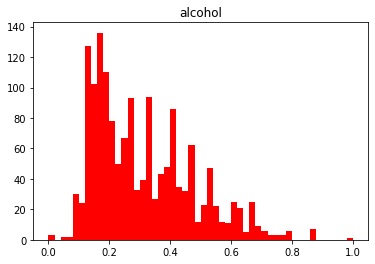

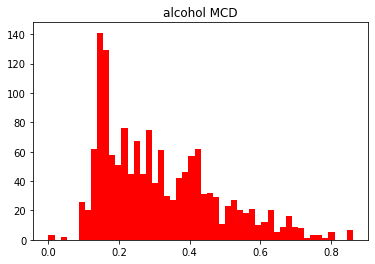

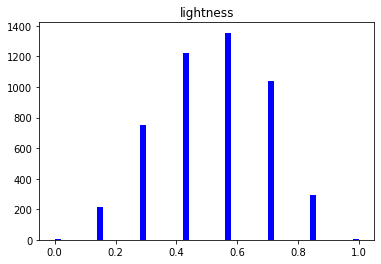

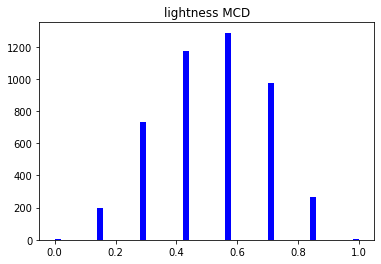

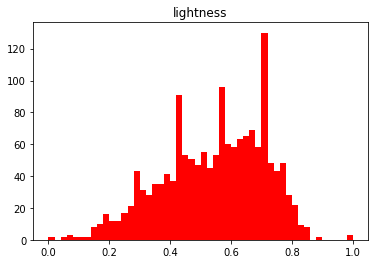

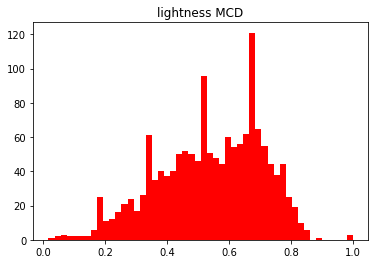

In [6]:
# Visualisierung

num_bins = 50

for col in x_white_scaled:
    #Plotte Weißwein
    plt.hist(x_white_scaled[col], num_bins, facecolor = "b")
    plt.title(col)
    plt.show()
    
    plt.hist(x_white_mcd[col], num_bins, facecolor = "b")
    plt.title(col + " MCD")
    plt.show()

    #Plotte Rotwein
    plt.hist(x_red_scaled[col], num_bins, facecolor = "r")
    plt.title(col)
    plt.show()
    
    plt.hist(x_red_mcd[col], num_bins, facecolor = "r")
    plt.title(col + " MCD")
    plt.show()

In [7]:
# Skalierung des MCD Outlier Datensatzes

x_red_mcd_scaled = min_max_scaler(x_red_mcd)
x_white_mcd_scaled = min_max_scaler(x_white_mcd)

#x_white_mcd_scaled["total sulfur dioxide"].max()

In [8]:
# Normalisieren

#PowerTransformer
def power_transformer(x):
    transformer = PowerTransformer()
    transformed = transformer.fit_transform(x)
    df_transformed = pd.DataFrame(transformed, columns = x.columns)
    return df_transformed

x_red_pt = power_transformer(x_red)
x_red_pt_scaled = min_max_scaler(x_red_pt)
x_white_pt = power_transformer(x_white)

x_red_mcd_scaled_pt = power_transformer(x_red_mcd_scaled)
x_white_mcd_scaled_pt = power_transformer(x_white_mcd_scaled)
x_white_mcd_scaled_pt

/home/dl4/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/dl4/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,magnesium,alcohol,lightness
0,0.252006,0.116682,0.335639,1.938946,0.274724,0.688266,0.795737,2.129781,-1.334455,-0.119008,-0.237138,-1.639249,1.924533
1,-0.632269,0.450011,0.157092,-1.099651,0.627133,-1.441453,-0.092160,0.074283,0.776307,0.229664,0.156505,-0.827961,0.280751
2,1.474699,0.231848,0.679177,0.346924,0.712304,-0.239407,-0.988266,0.441462,0.525985,0.229664,-0.342386,-0.239099,0.280751
3,0.488397,-0.389542,-0.026241,0.644940,1.355198,0.800250,1.146687,0.602054,0.067199,0.125484,-0.793967,-0.425922,1.093013
4,0.488397,-0.389542,-0.026241,0.644940,1.355198,0.800250,1.146687,0.602054,0.067199,0.090679,-0.793967,-0.425922,-0.511005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,-0.766452,-0.673444,-0.310691,-1.099651,-0.292103,-0.660724,-1.123275,-0.983570,0.589341,-0.829327,0.248559,0.649413,-0.511005
4632,-0.241907,0.653189,0.335639,0.556826,0.453326,1.325068,0.750967,0.376151,-0.207758,1.219779,-0.134726,-0.723678,1.093013
4633,-0.370049,-0.255683,-1.350945,-1.249771,-0.097749,-0.239407,-0.619888,-0.445514,-1.415584,1.421113,-0.134726,-0.934923,1.093013
4634,-1.768471,0.342893,-0.214576,-1.288500,-2.208815,-0.960392,-0.645744,-2.038189,1.018641,-0.901400,-1.039835,1.631095,-2.026893


In [9]:
# Datensätze generieren // Datensatzübersicht

############################
#### Normale Datensätze ####
############################
x_red, y_red
x_white, y_white

##############################
#### Skalierte Datensätze ####
##############################
# Normal
x_red_scaled, y_red
x_white_scaled, y_white

# Ohne Outlier (MCD)
x_red_mcd_scaled, y_red_mcd
x_white_mcd_scaled, y_white_mcd

###############################
#### Gefilterte Datensätze ####
###############################
"""Alle Outlier Datensätze arbeiten mit dem Skalierten [0-1] Datensatz, MCD (Beste Outlier Reduction) wurde daraufhin nochmals auf [0-1] skaliert damit man mit diesem weiterarbeiten kann"""

# Isolation Forest
x_red_iso, y_red_iso
x_white_iso, y_white_iso

# Local Outlier Factor
x_red_lof, y_red_lof
x_white_lof, y_white_lof

# Minimum Covariance Determinant
x_red_mcd, y_red_mcd
x_white_mcd, y_white_mcd
# Minimum Covariance Determinant (Skaliert)
x_red_mcd_scaled, y_red_mcd
x_white_mcd_scaled, y_white_mcd

# One-Class SVM
x_red_ocs, y_red_ocs
x_white_ocs, y_white_ocs

##############################
#### Normierte Datensätze ####
##############################

### PowerTransformer ###
#Normaler Datensatz
x_red_pt, y_red
#Normaler Datensatz (wieder auf [0-1] skaliert, macht wahrscheinlich keinen großen Unterschied, aber kann man mal experimentieren)
x_red_pt_scaled, y_red

# Ohne Outlier (MCD)
x_red_mcd_scaled_pt, y_red_mcd
x_white_mcd_scaled_pt, y_white_mcd



################################
#### Selektierte Datensätze ####
################################


#Zu Untersuchen. Datensatz ohne:
# Density
# Lightness
# pH bei Rotwein (wenn sklaierter Datensatz)

(      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0          0.252006          0.116682     0.335639        1.938946   0.274724   
 1         -0.632269          0.450011     0.157092       -1.099651   0.627133   
 2          1.474699          0.231848     0.679177        0.346924   0.712304   
 3          0.488397         -0.389542    -0.026241        0.644940   1.355198   
 4          0.488397         -0.389542    -0.026241        0.644940   1.355198   
 ...             ...               ...          ...             ...        ...   
 4631      -0.766452         -0.673444    -0.310691       -1.099651  -0.292103   
 4632      -0.241907          0.653189     0.335639        0.556826   0.453326   
 4633      -0.370049         -0.255683    -1.350945       -1.249771  -0.097749   
 4634      -1.768471          0.342893    -0.214576       -1.288500  -2.208815   
 4635      -1.041236         -0.673444     0.509603       -1.407697  -2.471636   
 
       free su

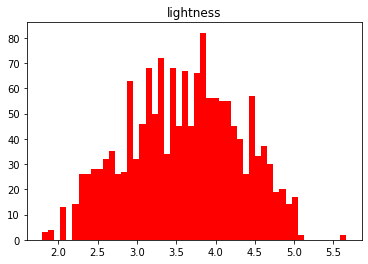

11.3


In [10]:
# Log-Nomralisierung

# Visualisierung

num_bins = 50

ln = np.log(x_red["total sulfur dioxide"])
plt.hist(ln, num_bins, facecolor = "r")
plt.title(col)
plt.show()

print(x_red["pH"].max())

In [28]:
vif_factors= pd.Series([variance_inflation_factor(x_red.values, i) for i in range(x_red.shape[1])], index=x_red.columns)
print("\nRotwein")
print("VIF: \n",vif_factors)

vif_factors= pd.Series([variance_inflation_factor(x_red_scaled.values, i) for i in range(x_red_scaled.shape[1])], index=x_red_scaled.columns)
print("\nRotwein Skaliert")
print("VIF: \n",vif_factors)

vif_factors= pd.Series([variance_inflation_factor(x_red_mcd_scaled.values, i) for i in range(x_red_mcd_scaled.shape[1])], index=x_red_mcd_scaled.columns)
print("\nRotwein Skaliert, ohne Outlier")
print("VIF: \n",vif_factors)

vif_factors= pd.Series([variance_inflation_factor(x_red_mcd_scaled_pt.values, i) for i in range(x_red_mcd_scaled_pt.shape[1])], index=x_red_mcd_scaled_pt.columns)
print("\nRotwein Skaliert Powertransformer, ohne Outlier: x_red_mcd_scaled_pt")
print("VIF: \n",vif_factors)

print("\n\n")

vif_factors= pd.Series([variance_inflation_factor(x_white_scaled.values, i) for i in range(x_white_scaled.shape[1])], index=x_white_scaled.columns)
print("\nWeißwein Skaliert: x_white_scaled")
print("VIF: \n",vif_factors)

vif_factors= pd.Series([variance_inflation_factor(x_white_mcd.values, i) for i in range(x_white_mcd.shape[1])], index=x_white_mcd.columns)
print("\nWeißwein Skaliert, ohne Outlier: x_white_mcd")
print("VIF: \n",vif_factors)

vif_factors= pd.Series([variance_inflation_factor(x_white_mcd_scaled_pt.values, i) for i in range(x_white_mcd_scaled_pt.shape[1])], index=x_white_mcd_scaled_pt.columns)
print("\nWeißwein Skaliert Powertransformer, ohne Outlier x_white_mcd_scaled_pt")
print("VIF: \n",vif_factors)


Rotwein
VIF: 
 fixed acidity             53.426067
volatile acidity          16.703346
citric acid                9.108963
residual sugar             4.661322
chlorides                  6.307859
free sulfur dioxide        6.356018
total sulfur dioxide       6.301839
density                 4003.421361
pH                        85.040860
sulphates                 21.438226
magnesium                  4.047249
alcohol                  858.229937
lightness               1079.426466
dtype: float64

Rotwein Skaliert
VIF: 
 fixed acidity           13.194483
volatile acidity        10.337223
citric acid              9.103255
residual sugar           2.636330
chlorides                5.241178
free sulfur dioxide      5.742105
total sulfur dioxide     5.284688
density                 10.645272
pH                       3.659068
sulphates                6.286883
magnesium                4.016390
alcohol                  6.922062
lightness               18.308691
dtype: float64

Rotwein Skaliert, 

[[-0.02076869 -0.49389477]
 [ 0.06154413 -0.11556111]
 [ 0.0623378  -0.06382425]
 ...
 [ 0.42026906 -0.21763334]
 [-0.27760481  0.56084329]
 [-0.41925079  0.34569755]]


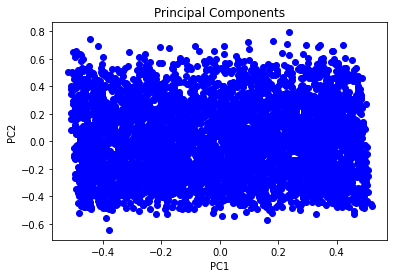

In [12]:
# PCA

pca = PCA(n_components=2)
new_dataset = pca.fit_transform(x_white_scaled)

print(new_dataset)

plt.scatter(new_dataset[:,0], new_dataset[:,1], color = "b")
plt.title('Principal Components')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

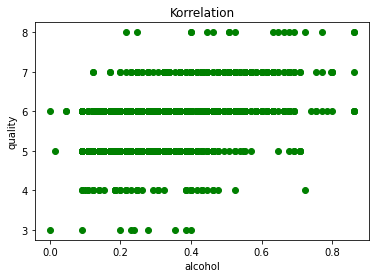

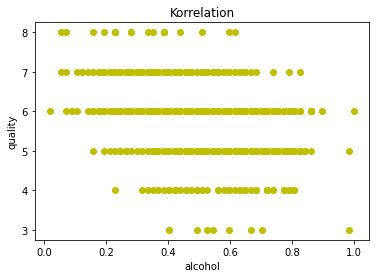

In [13]:
# Visualisierung Rotwein ; Korrelation Qualität & Alcohol/Lightness

plt.scatter(x_red_mcd["alcohol"], y_red_mcd, color = "g")
plt.title('Korrelation')
plt.xlabel('alcohol')
plt.ylabel("quality")
plt.show()

plt.scatter(x_red_mcd["lightness"], y_red_mcd, color = "y")
plt.title('Korrelation')
plt.xlabel('alcohol')
plt.ylabel("quality")
plt.show()